# Transfer Learning for Image Classification with PyTorch

In this project, we will use the PyTorch library to classify images of cats and dogs. Image classification is a common task in computer vision, and deep learning models have significantly improved performance in this area. Instead of training a model from scratch, we will leverage transfer learning, a powerful technique that utilizes a pre-trained model as a starting point. This approach can save substantial time and computational resources while often resulting in improved accuracy.

We will employ a pre-trained model, such as ResNet, VGG, or Inception, which has been trained on a large dataset like ImageNet. By fine-tuning this model on our specific dataset of cat and dog images, we can adapt the high-level features learned from the large dataset to our specific classification task. This involves modifying the final layers of the pre-trained model to suit the number of classes in our dataset and then retraining these layers on our cat and dog images.

Throughout this project, we will explore the following steps:

- Dataset Preparation: Loading and preprocessing the dataset of cat and dog images.
- Model Selection: Choosing an appropriate pre-trained model for transfer learning.
- Fine-Tuning: Modifying and training the model on our dataset.
- Evaluation: Assessing the performance of the fine-tuned model on a test set.
- Deployment: Making predictions on new, unseen images.

By the end of this project, you will have a solid understanding of how to apply transfer learning to image classification tasks using PyTorch, and you'll be able to extend these techniques to other datasets and models.

# References

In [1]:
import random
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
from torchvision import transforms
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preparation

In [3]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ),
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder("datasets/dogs_v_cats/train", transform=train_transform)
valid_dataset = torchvision.datasets.ImageFolder("datasets/dogs_v_cats/val", transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder("datasets/dogs_v_cats/test", transform=train_transform)

In [5]:
for image,label in valid_dataset:
    print(image.shape)
    break

torch.Size([3, 224, 224])


In [6]:
# check class names
print(valid_dataset.classes)

['cat', 'dog']


In [7]:
batch_size_train = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_train, shuffle=False)

In [8]:
iter_ = iter(train_loader)
image,label = next(iter_)
print(image.shape)
print(label)

torch.Size([64, 3, 224, 224])
tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0])


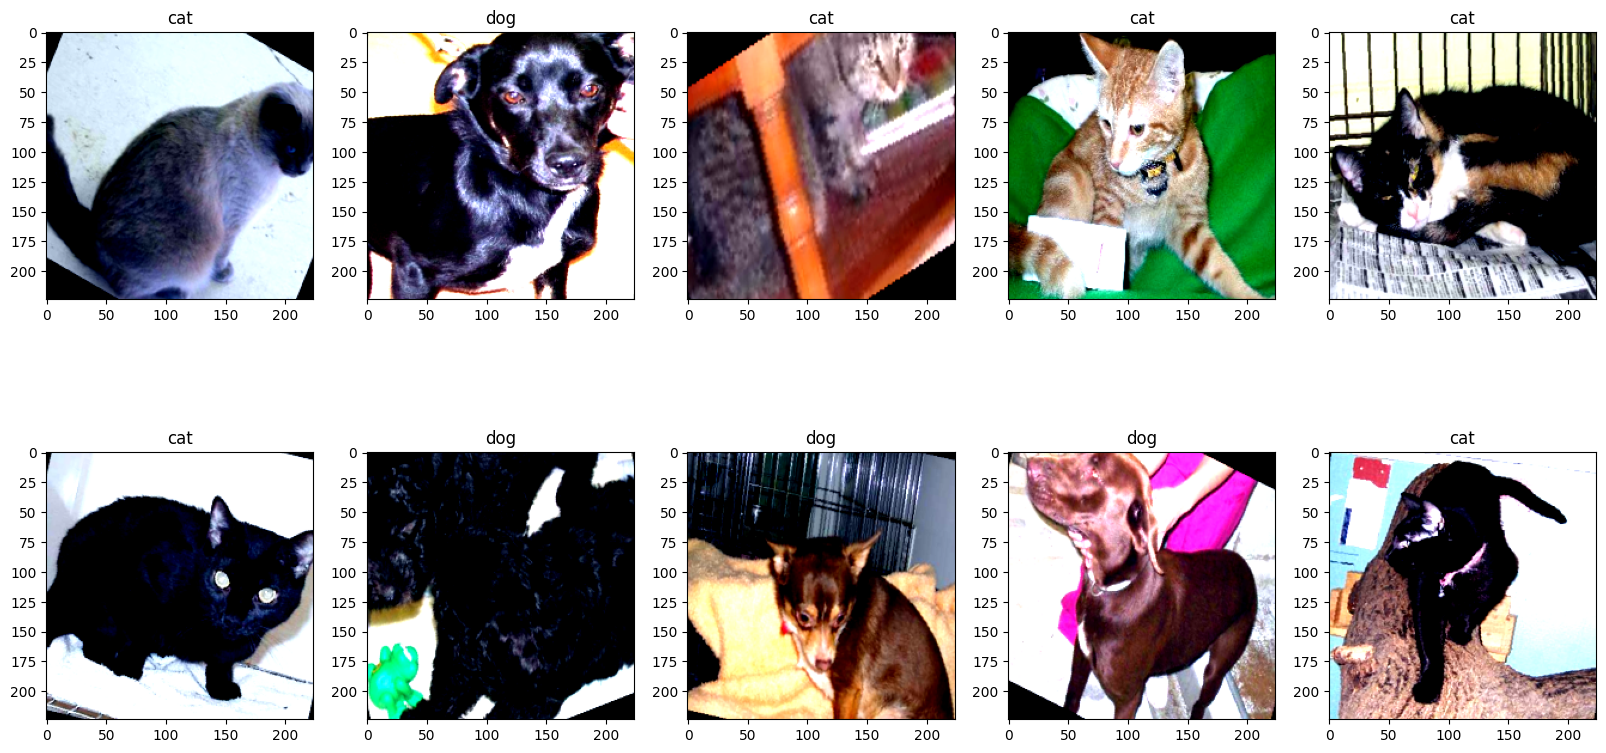

In [20]:
def image_convert(
    img, 
    std=[0.5, 0.5, 0.5], 
    mean=[0.5, 0.5, 0.5]
    ):
    img = img.clone().cpu().numpy()
    img = img.transpose(1, 2, 0)
    img = img * std + mean
    img = img.clip(0, 1)
    return img

def plot_sample_images(dataloader=train_loader, n_images=batch_size_train):
        iter_ = iter(dataloader)
        images,labels = next(iter_)
        map_to_class = {'0':'cat','1':'dog'}
        
        plt.figure(figsize=(20,10))
        for idx in range(n_images):
            plt.subplot(2,5,idx+1)
            img = image_convert(images[idx])
            label = labels[idx]
            plt.imshow(img)
            plt.title(map_to_class[str(label.numpy())])
        plt.show()

plot_sample_images(n_images=10)

### Building the Network

In [10]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
class classification_head(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(512,512)
        self.linear2=nn.Linear(512,2)
    
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [12]:
model_ = classification_head().to(device)
model.fc = model_

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# freeze all layers
for param in model.parameters():
        param.requires_grad = False
# unfreeze the last layer
for param in model.fc.parameters():
        param.requires_grad = True

### Define training loop

In [15]:
def train_classification(model, data_loader, optimizer, criterion, device):
    model.to(device).train()
    batch_loss = []
    correct = 0
    total_samples = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        correct += (y_hat.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy

def validate_classification(model, data_loader, criterion, device):
    model.to(device).eval()
    batch_loss = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            batch_loss.append(loss.item())
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy

def evaluate_classification(model, data_loader, device):
    model.to(device).eval()
    correct = 0
    total_samples = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            predictions.append(y_hat.argmax(1))
            actuals.append(y)
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    actuals = torch.cat(actuals, dim=0).cpu().numpy()
    accuracy = 100.0 * correct / total_samples

    return predictions, actuals, accuracy

def predict_classification(model, data_loader, device):
    model.to(device).eval()
    predictions = []

    with torch.no_grad():
        for x_batch in data_loader:
            x_batch = x_batch.to(device)
            y_hat = model(x_batch)
            predictions.append(y_hat.argmax(dim=1))

    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    return predictions

class EarlyStopper:
    def __init__(
        self, patience: int = 1, min_delta: float = 0.0, verbose: bool = False
    ):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.best_model_weights = None
        self.verbose = verbose

    def early_stop(self, loss:float, model:nn.Module):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"Early Stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [16]:
# lists to store loss and accuracy
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# training lists and parameters
n_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model, optimizer, loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)
early_stopper = EarlyStopper(patience=10, min_delta=0.0001)

In [17]:
for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    epoch_train_loss, epoch_train_acc = train_classification(model, train_loader, optimizer, criterion, device)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_acc)

    epoch_val_loss, epoch_val_acc = validate_classification(model, val_loader, criterion, device)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_acc)

    print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_train_loss:.4f} acc: {epoch_train_acc:.2f}% - Val loss: {epoch_val_loss:.4f} acc: {epoch_val_acc:.2f}%')
    
    if early_stopper.early_stop(epoch_val_loss, model):
        early_stopper.restore_best_weights(model)
        print("Early Stopping triggered: Restoring best weights")
        break

Training Progress:  33%|███▎      | 1/3 [01:08<02:16, 68.49s/it]

[1/3] Train loss: 26.0544 acc: 90.08% - Val loss: 3.2673 acc: 97.15%


Training Progress:  67%|██████▋   | 2/3 [02:21<01:11, 71.32s/it]

[2/3] Train loss: 11.3248 acc: 93.06% - Val loss: 9.8639 acc: 93.50%


Training Progress: 100%|██████████| 3/3 [03:35<00:00, 71.86s/it]

[3/3] Train loss: 13.4181 acc: 92.36% - Val loss: 4.6587 acc: 97.02%


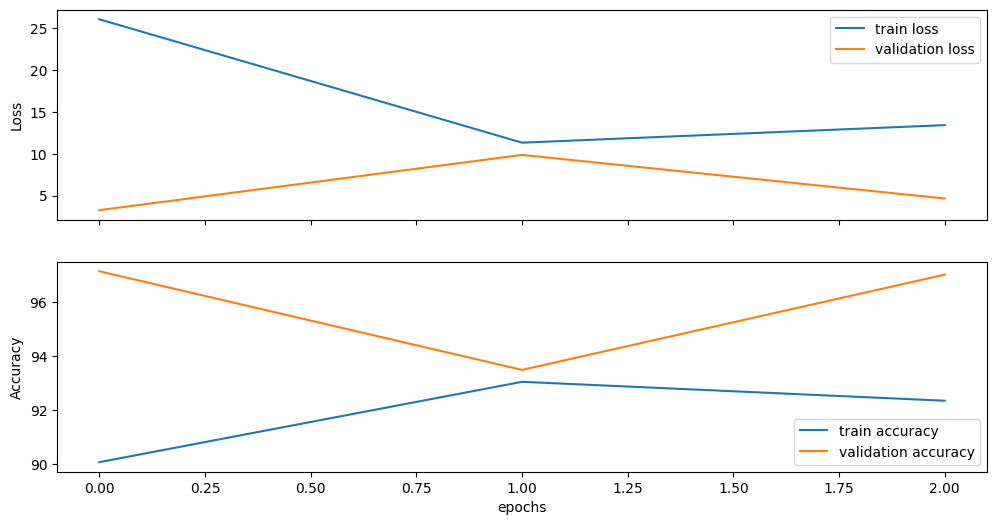

In [18]:
# plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(train_loss, label="train loss")
ax1.plot(val_loss, label="validation loss")
ax1.set_ylabel("Loss")
ax2.plot(train_accuracy, label="train accuracy")
ax2.plot(val_accuracy, label="validation accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs")
ax1.legend()
ax2.legend()

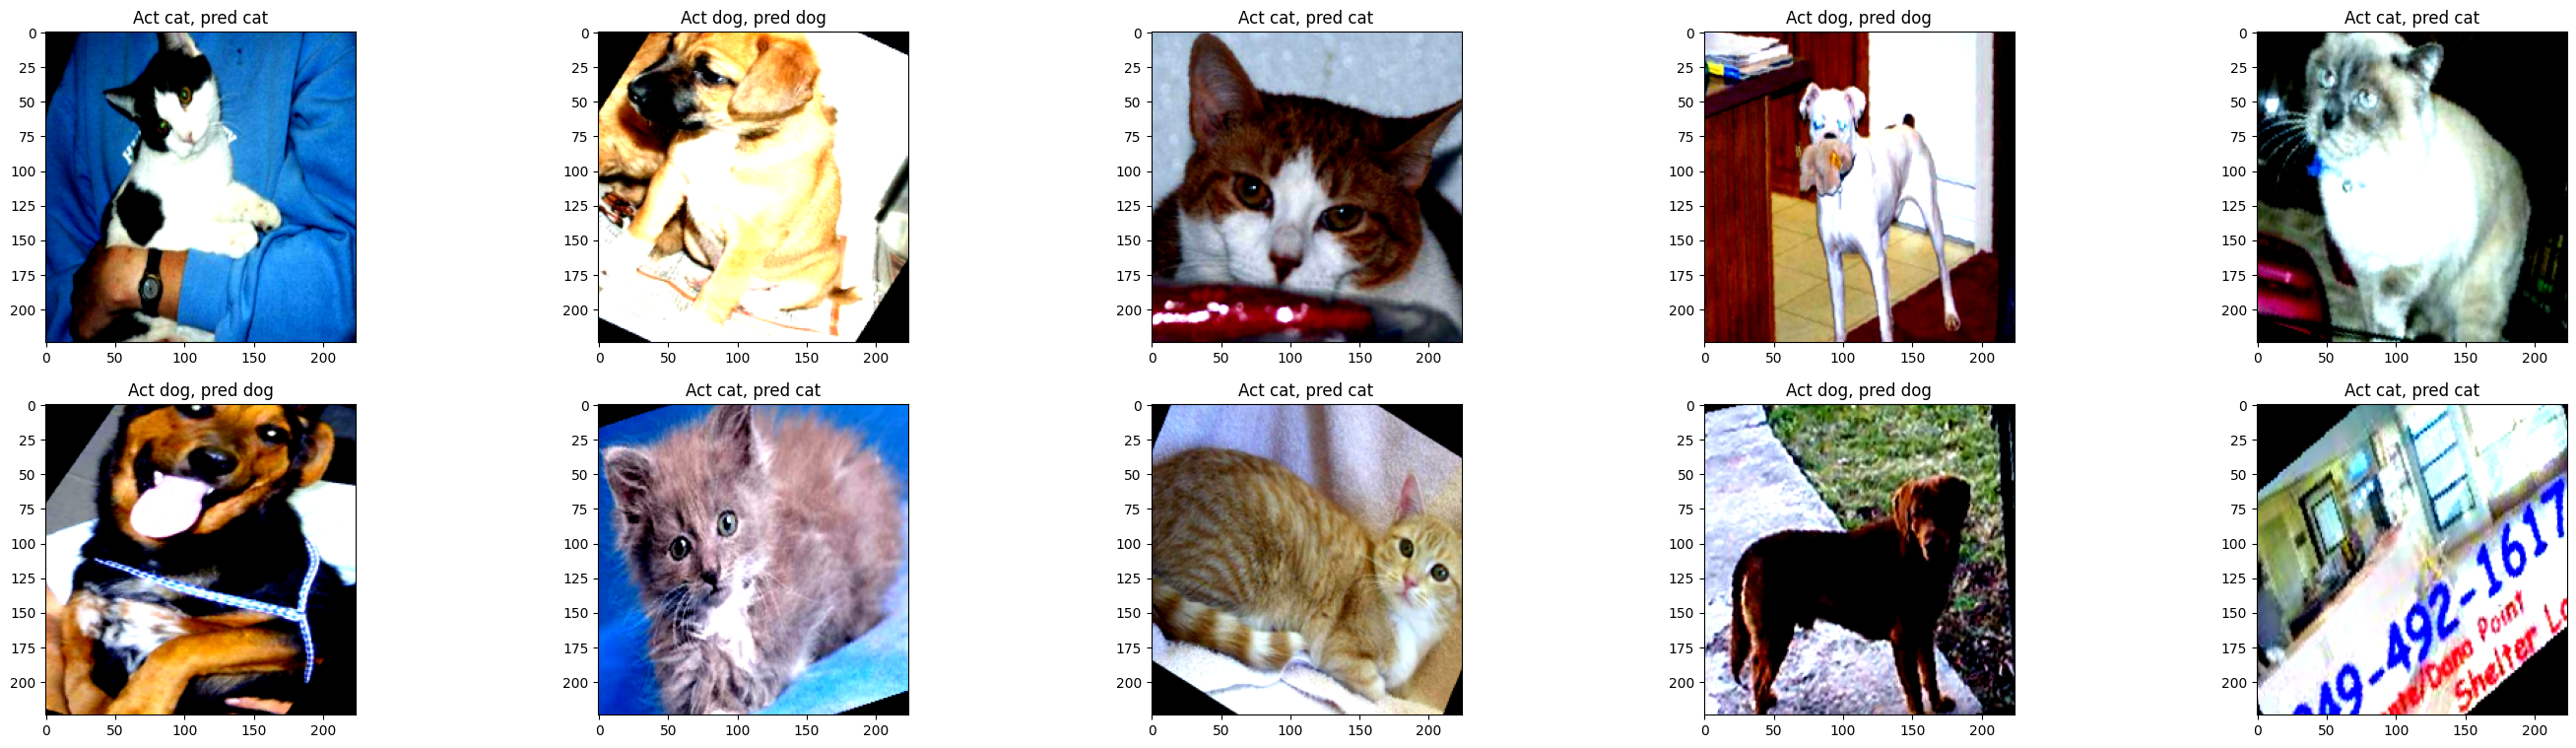

In [21]:
def plot_val_images(data_loader=test_loader, num_images=10):
    label_dict = ['cat', 'dog']
    
    # Get a batch of data from the data loader
    images, labels = next(iter(data_loader))
    images = images.to(device)
    labels = labels.to(device)
    
    # Randomly sample indices for the images to be plotted
    indices = random.sample(range(len(images)), num_images)
    
    fig = plt.figure(figsize=(35, 9))
    for idx, image_idx in enumerate(indices):
        ax = fig.add_subplot(2, 5, idx + 1)
        plt.imshow(image_convert(images[image_idx]))
        label = labels[image_idx]
        pred_label = labels[image_idx]  # Assuming you want to show the true label as the predicted label here
        ax.set_title('Act {}, pred {}'.format(label_dict[label], label_dict[pred_label]))
    plt.show()

plot_val_images(train_loader)